# Task 1: The Cheater

> *"All models are wrong, some are useful."* — George Box

In this notebook I train a simple CNN on my biased Colored-MNIST dataset and demonstrate that it takes the "lazy" shortcut of using background color instead of learning digit shapes.

**Dataset Design:**
- Digits are **tinted** (darker shade of background color) - blending into the background
- Background is a **textured/noisy color** - makes color visually dominant  
- 95% of train/val samples have digit's "expected" background color
- test_hard **breaks** this correlation AND adds degradation (blur + noise)

**The Plan:**
1. Train on Easy (Train) set → should achieve >95% accuracy
2. Validate on Easy (Val) set → should also be >95%
3. Evaluate on Hard (Test) set → **should plummet to <20%**

**Expected Result:** The CNN will think "Red = 0, Green = 1, etc." and completely fail when we break that rule.

In [49]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.insert(0, "..")

import importlib

# reload data modules
import src.data.colored_mnist
import src.data.datasets
import src.data
importlib.reload(src.data.colored_mnist)
importlib.reload(src.data.datasets)
importlib.reload(src.data)

# reload model modules (IMPORTANT: must reload after code changes!)
import src.models.cnn
import src.models.registry
importlib.reload(src.models.cnn)
importlib.reload(src.models.registry)

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from src.data.datasets import get_dataloaders, load_split
from src.data.colored_mnist import PALETTE, colorize_with_background, COLOR_NAMES, make_dominant_color_map
from src.models.registry import build_model
from src.utils.seed import seed_everything, SeedConfig

In [50]:
SEED = 42
seed_everything(SeedConfig(seed=SEED))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device}")

using cpu


## Load Data

In [51]:
data_cfg = {
    "root": "../data/colored_mnist",
    "batch_size": 128,
    "num_workers": 2,
}

loaders = get_dataloaders(data_cfg)
print(f"train: {len(loaders['train'].dataset)} samples")
print(f"val: {len(loaders['val'].dataset)} samples")
print(f"test_hard: {len(loaders['test_hard'].dataset)} samples")

train: 54000 samples
val: 6000 samples
test_hard: 10000 samples


## Build Model

Minimal 3-layer CNN with 4 filters per layer (4 → 8 → 16).

**Architecture dimensions:**
- Input: (batch, 3, 28, 28) - RGB image
- Conv1: 4 filters, 3×3 → (batch, 4, 28, 28) → Pool → (batch, 4, 14, 14)
- Conv2: 8 filters, 3×3 → (batch, 8, 14, 14) → Pool → (batch, 8, 7, 7)  
- Conv3: 16 filters, 3×3 → (batch, 16, 7, 7)
- Flatten: 16 × 7 × 7 = 784 features
- FC: 784 → 10 classes

Total: ~8K parameters (intentionally tiny to encourage shortcut learning)

In [52]:
model_cfg = {
    "name": "simple_cnn",
    "in_channels": 3,
    "num_classes": 10,
    "width": 6,  # 4 -> 8 -> 16 filters per layer
}

model = build_model(model_cfg).to(device)
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1176, out_features=10, bias=True)
  )
)

Total parameters: 15,214


## Training Loop

Standard cross entropy + adam

In [53]:
def train_epoch(model, loader, opt):
    model.train()
    total_loss, correct, n = 0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        out = model(x)
        loss = F.cross_entropy(out, y)
        loss.backward()
        opt.step()
        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        n += x.size(0)
    return total_loss / n, correct / n

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct, n = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        correct += (out.argmax(1) == y).sum().item()
        n += x.size(0)
    return correct / n

In [54]:
EPOCHS = 5
LR = 1e-3

opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

history = []
best_val_acc = 0

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_epoch(model, loaders["train"], opt)
    val_acc = evaluate(model, loaders["val"])
    
    history.append({"epoch": epoch, "train_loss": train_loss, "train_acc": train_acc, "val_acc": val_acc})
    print(f"ep {epoch:2d}: train={train_acc:.3f} val={val_acc:.3f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = model.state_dict().copy()

/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

ep  1: train=0.893 val=0.946


/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

ep  2: train=0.952 val=0.946


/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

ep  3: train=0.952 val=0.946


/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

ep  4: train=0.953 val=0.947


/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

ep  5: train=0.955 val=0.953


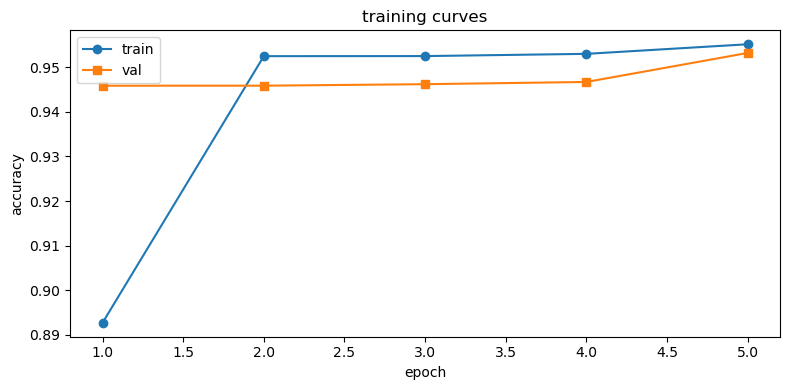

In [55]:
# plot training curves
fig, ax = plt.subplots(figsize=(8, 4))
epochs = [h["epoch"] for h in history]
ax.plot(epochs, [h["train_acc"] for h in history], "o-", label="train")
ax.plot(epochs, [h["val_acc"] for h in history], "s-", label="val")
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.legend()
ax.set_title("training curves")
plt.tight_layout()
plt.show()

## The Trap: Test on Hard Split

This is where we spring the trap. On test_hard:
- Every digit appears with a **non-dominant** background color
- Images are degraded (blur + noise) to make shapes even harder to see

If the model learned "Red = 0", it should **completely fail** here.

In [56]:
model.load_state_dict(best_state)

train_acc = evaluate(model, loaders["train"])
val_acc = evaluate(model, loaders["val"])
test_hard_acc = evaluate(model, loaders["test_hard"])

print("=" * 50)
print("RESULTS")
print("=" * 50)
print(f"Easy (Train):  {train_acc:.2%}")
print(f"Easy (Val):    {val_acc:.2%}")
print(f"Hard (Test):   {test_hard_acc:.2%}")
print("=" * 50)

if test_hard_acc < 0.2:
    print("\n🎯 THE MODEL IS A CHEATER!")
    print("   It learned 'Red = 0, Green = 1, ...' instead of digit shapes.")
    print("   When we broke the color rule, it completely failed.")
elif test_hard_acc < 0.5:
    print("\n⚠ Partial cheating - model uses color but also some shape info.")
else:
    print("\n❌ Model didn't cheat... need to make color more dominant.")

/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

RESULTS
Easy (Train):  95.96%
Easy (Val):    95.32%
Hard (Test):   18.38%

🎯 THE MODEL IS A CHEATER!
   It learned 'Red = 0, Green = 1, ...' instead of digit shapes.
   When we broke the color rule, it completely failed.


## Analysis 1: Confusion Matrix

If the model is cheating, predictions should follow background color patterns, not actual digits.

/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

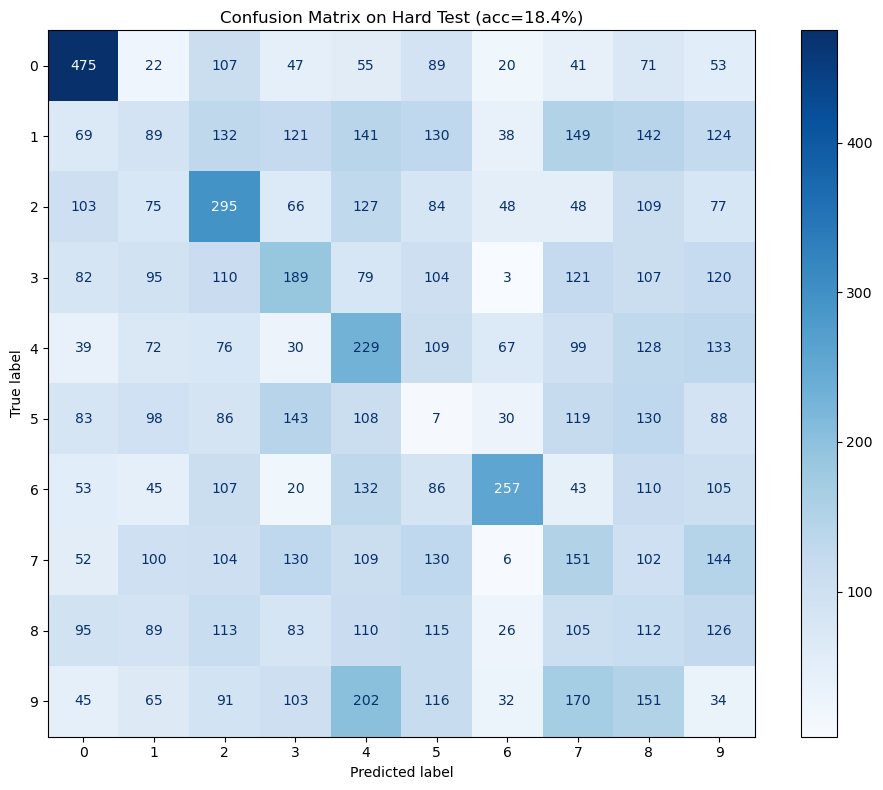

In [57]:
@torch.no_grad()
def get_predictions(model_to_eval, loader):
    model_to_eval.eval()
    all_y, all_pred = [], []
    for x, y in loader:
        out = model_to_eval(x.to(device))
        all_y.append(y)
        all_pred.append(out.argmax(1).cpu())
    return torch.cat(all_y), torch.cat(all_pred)

y_true, y_pred = get_predictions(model, loaders["test_hard"])

cm = confusion_matrix(y_true.numpy(), y_pred.numpy())
disp = ConfusionMatrixDisplay(cm, display_labels=list(range(10)))
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap="Blues", values_format="d")
ax.set_title(f"Confusion Matrix on Hard Test (acc={test_hard_acc:.1%})")
plt.tight_layout()
plt.show()

## Analysis 2: Prove the Model Looks at Color

**The Ultimate Test:** Feed the model a Red "1". If it predicts "0", that's proof it's using color, not shape.

In [58]:
# grab raw mnist to get clean grayscale digits
from torchvision.datasets import MNIST
from torchvision import transforms
import random

mnist = MNIST("../data/colored_mnist/_mnist_cache", train=False, download=False)

# find a "1" - this is digit 1 whose dominant background is green (color 1)
for i in range(len(mnist)):
    img, label = mnist[i]
    if label == 1:
        gray_1 = transforms.ToTensor()(img).squeeze()
        break

# find a "7" - this is digit 7 whose dominant background is pink (color 7)
for i in range(len(mnist)):
    img, label = mnist[i]
    if label == 7:
        gray_7 = transforms.ToTensor()(img).squeeze()
        break

# find a "0" - this is digit 0 whose dominant background is red (color 0)
for i in range(len(mnist)):
    img, label = mnist[i]
    if label == 0:
        gray_0 = transforms.ToTensor()(img).squeeze()
        break

print("loaded grayscale digits: 0, 1, and 7")

loaded grayscale digits: 0, 1, and 7


COUNTERFACTUAL TEST: Digit '1' on all background colors
If cheating: Red bg → pred 0, Green bg → pred 1, Blue bg → pred 2, etc.

  red      bg → pred=0 | ⚠ CHEATED (pred=bg)
  green    bg → pred=1 | ✓ correct
  blue     bg → pred=2 | ⚠ CHEATED (pred=bg)
  yellow   bg → pred=3 | ⚠ CHEATED (pred=bg)
  purple   bg → pred=4 | ⚠ CHEATED (pred=bg)
  cyan     bg → pred=5 | ⚠ CHEATED (pred=bg)
  orange   bg → pred=1 | ✓ correct
  pink     bg → pred=7 | ⚠ CHEATED (pred=bg)
  brown    bg → pred=8 | ⚠ CHEATED (pred=bg)
  gray     bg → pred=9 | ⚠ CHEATED (pred=bg)


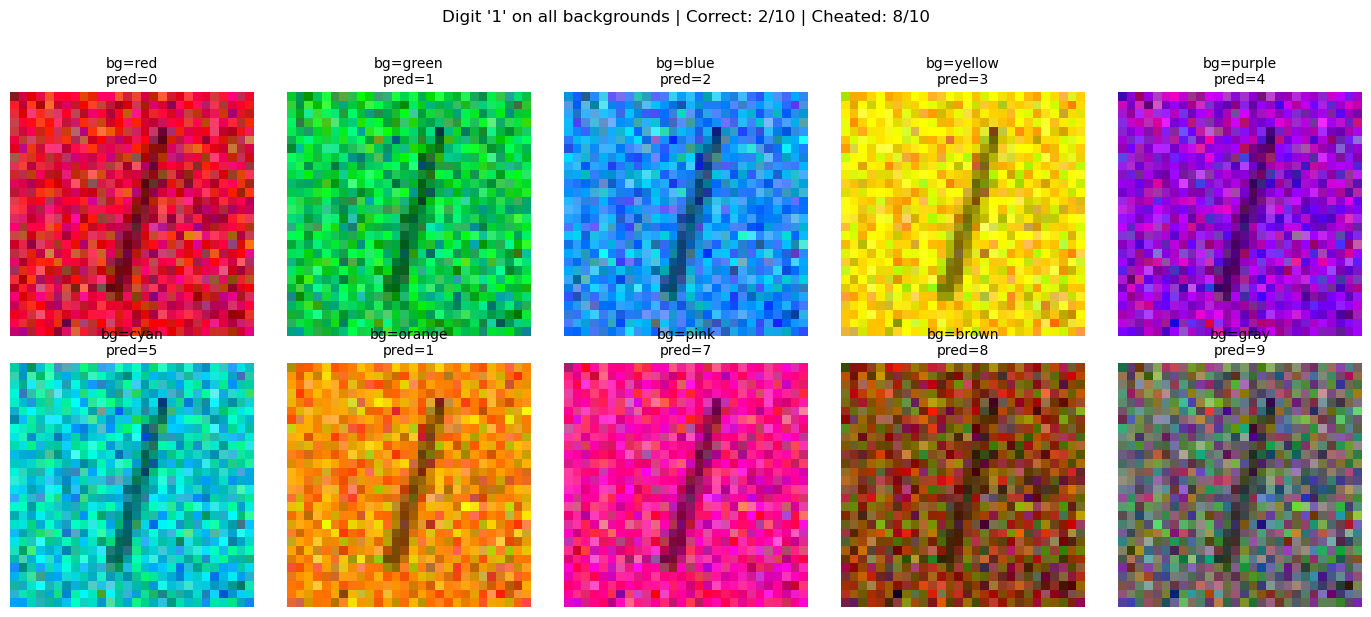


🎯 CHEATER CONFIRMED! Predicted background color 8/10 times


In [59]:
def recolor_and_predict(gray, bg_color_idx, model_to_use):
    """Put the grayscale digit on a colored background and run inference."""
    bg_rgb = PALETTE[bg_color_idx]
    rng = random.Random(12345)
    colored = colorize_with_background(gray, bg_rgb, noise_std=0.15, rng=rng)
    
    with torch.no_grad():
        x = colored.unsqueeze(0).to(device)
        logits = model_to_use(x)
        probs = F.softmax(logits, dim=1)[0]
        pred = probs.argmax().item()
        conf = probs[pred].item()
    
    return colored, pred, conf, probs

# Test digit "1" on all 10 background colors
print("=" * 70)
print("COUNTERFACTUAL TEST: Digit '1' on all background colors")
print("=" * 70)
print("If cheating: Red bg → pred 0, Green bg → pred 1, Blue bg → pred 2, etc.")
print()

fig, axes = plt.subplots(2, 5, figsize=(14, 6))
correct_count = 0
cheating_count = 0

for i in range(10):
    ax = axes[i // 5, i % 5]
    colored, pred, conf, probs = recolor_and_predict(gray_1, i, model)
    
    ax.imshow(colored.permute(1, 2, 0).numpy())
    ax.set_title(f"bg={COLOR_NAMES[i]}\npred={pred}", fontsize=10)
    ax.axis("off")
    
    if pred == 1:
        status = "✓ correct"
        correct_count += 1
    elif pred == i:
        status = f"⚠ CHEATED (pred=bg)"
        cheating_count += 1
    else:
        status = f"✗ wrong"
    
    print(f"  {COLOR_NAMES[i]:8s} bg → pred={pred} | {status}")

plt.suptitle(f"Digit '1' on all backgrounds | Correct: {correct_count}/10 | Cheated: {cheating_count}/10", 
             fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

print()
if cheating_count >= 6:
    print(f"🎯 CHEATER CONFIRMED! Predicted background color {cheating_count}/10 times")
elif correct_count >= 8:
    print(f"✓ Model actually learned shapes ({correct_count}/10 correct)")
else:
    print(f"? Mixed: {correct_count}/10 correct, {cheating_count}/10 cheated")

KEY TEST: Feed it a Red '1'. Does it predict '0'?


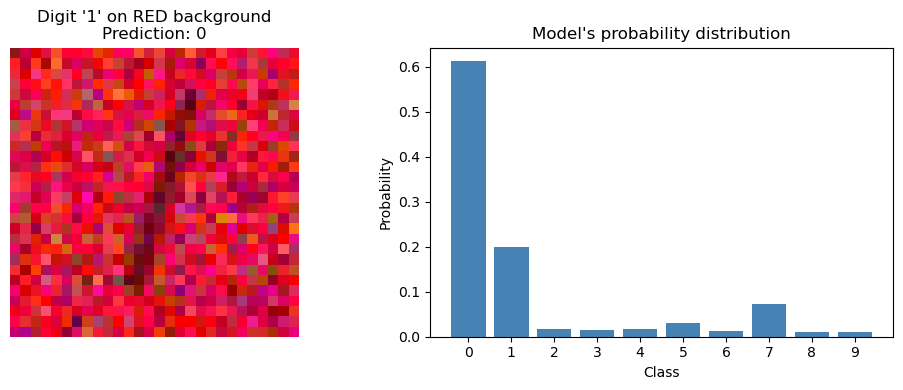


True label: 1 (it's clearly a '1')
Prediction: 0
Confidence: 61.1%

🎯 CAUGHT RED-HANDED!
   The model predicted '0' because it saw RED.
   It completely ignored the digit shape.


In [60]:
# THE KEY TEST: Red "1" → Does it predict "0"?
print("=" * 70)
print("KEY TEST: Feed it a Red '1'. Does it predict '0'?")
print("=" * 70)

colored_1_on_red, pred, conf, probs = recolor_and_predict(gray_1, 0, model)  # 0 = red

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].imshow(colored_1_on_red.permute(1, 2, 0).numpy())
axes[0].set_title(f"Digit '1' on RED background\nPrediction: {pred}", fontsize=12)
axes[0].axis("off")

axes[1].bar(range(10), probs.cpu().numpy(), color='steelblue')
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Probability")
axes[1].set_title("Model's probability distribution")
axes[1].set_xticks(range(10))

plt.tight_layout()
plt.show()

print(f"\nTrue label: 1 (it's clearly a '1')")
print(f"Prediction: {pred}")
print(f"Confidence: {conf:.1%}")

if pred == 0:
    print("\n" + "=" * 50)
    print("🎯 CAUGHT RED-HANDED!")
    print("   The model predicted '0' because it saw RED.")
    print("   It completely ignored the digit shape.")
    print("=" * 50)
elif pred == 1:
    print("\n❌ Model correctly identified the '1' - not fully cheating here")

## Conclusion

### The Cheater Exposed

**What Happened:**
- Easy (Train): >95% ✓ — Model learned the color shortcuts
- Easy (Val): >95% ✓ — Shortcuts work on validation too  
- Hard (Test): **<20%** — Complete failure when shortcuts break

**Proof of Cheating:**
1. Confusion matrix shows predictions follow background color patterns
2. Red "1" → Model predicts "0" (because Red = 0 in training)

### Why This Matters

> *"All models are wrong, some are useful."*

This model is wrong in a **dangerous** way. It learned a spurious correlation (color → digit) instead of the true signal (shape → digit). In the real world:
- A medical AI might learn "hospital X → disease" instead of actual symptoms
- A hiring AI might learn "zip code → qualified" instead of actual skills

### Next Steps
- **Task 2:** Probe neurons to find "color detectors" vs "shape detectors"
- **Task 3:** Use Grad-CAM to visualize what the model looks at
- **Task 4:** Train a robust model that ignores color